<a href="https://colab.research.google.com/github/rossamurphy/pytorch-sentiment-analysis/blob/master/assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7: Unsupervised learning (PCA, K-Means)

## Introduction

In this assignment, you will need to compute the Principal Component Analysis and K-Means algorithms and use them on a dataset. The dataset is the set of images from MNIST database corresponding to the handwritten digit $7$. Each image is $28px\times 28px$. The set is divided in a training set and a testing set of respective size $3133$ and $3132$.

As usual, the structure of the code is given to you and you need to fill the parts corresponding to the questions below.


## Questions

### PCA <a href='#pca'>Starts here</a>
<b><a href='#q1'>Question 1 (25%)</a></b>  Complete the functions `pca(.)` and `pca_project(.)`. For information, the function `np.linalg.eigh` compute the eigenvalues and eigenvectors of a symmetric matrix. It returns two arrays, the first one contains the eigenvalues in ascending order and the second one the corresponding eigenvector.<br/>
<b><a href='#q2'>Question 2 (15%)</a></b> Use the function `pca(.)` to learn a decomposition on the <b>training set</b>. Then compute the reconstruction error $E$ on the <b>testing set</b>, for a number of components varying from 1 to 100, as defined by: 
$$
E(D) = \frac{1}{N}\sum_{n=1}^N \|I_n - (\mathbf{\mu}+\sum_{k=1}^D \omega_k^n\mathbf{u}_k) \|_2,
$$
with $I_n$ denoting the $n$-th image of the testing set, $\mathbf{\mu}$ is the mean digit learnt from the training set, $\mathbf{u}_k$ is the eigenvector with the $k$-th largest eigenvalue, and $\omega_k^n$ is the expansion coefficient of the $n$-th image on the $k$-th eigenvector. Finally, $\|.\|_2$ denotes the $L_2$ norm. Numpy has the method `np.linalg.norm(.)` that computes norms (check out the documentation for more infos).
<br/>
<b><a href='#q3'>Question 3 (5%)</a></b> Plot the evolution of the error $E$ for $D = 1,\ldots,100$.

### K-means <a href='#kmeans'>Starts here</a>
<b><a href='#q4'>Question 4 (10%)</a></b> Complete the function `distortion(.)` which computes the distortion cost $F$ for a given clustering of the data:
$$
F(m,c) = \frac{1}{N}\sum_{i=1}^N \|x^i - c^{m(i)}\|_2,
$$
where $N$ corresponds to the total number of images in the set and $m(i)$ denotes which cluster is assigned to the image $x^i$.<br/>
<b><a href='#q5'>Question 5 (15%)</a></b> Complete the functions `kmeans(.)` and `assign_cluster(.)`, make sure that it computes the distortion after each update. Then use the function on your training set, the number of cluster $k = 2$. Check that the distortion decreases as the algorithm progresses.<br/>
<b><a href='#q6'>Question 6 (15%)</a></b> In order to mitigate the local minima problem of K-Means, repeat the algorithm $10$ times, and keep the solution that yields the smallest distortion at the end. Show the resulting digit clusters (centroids of your clusters) using the `plot_kmeans(.)` function given.<br/>
<b><a href='#q7'>Question 7 (10%)</a></b> Repeat the procedure of Question 6 for values of $k = 3,4,5,10,50,100$ (Allow for ~10min). Plot the evolution of the distortion cost of the training and testing data. Remember to use the functions `select_clustering(.)`, `assign_cluster(.)`, and `distortion(.)` defined earlier.<br/>

### Comparison <a href='#comparison'>Starts here</a>
<b><a href='#q8'>Question 8 (5%)</a></b> Compare the results from PCA to the results of K-means on the <b>test set</b> by plotting on the same graph the reconstruction error $E(D)$ for $D = 3,4,5,10,50,100$ and the distortion cost you just computed (remark that the two measures are simply $L_2$ norms thus the comparison is valid). To be clear, the first one measure the error in the reconstructed image from the projection on the components of PCA, the second measure the error between each image and the centroid of the cluster it is assigned to. Both correpond to the error made when approximating the original image to either its projection or its cluster's centroid.



### Importing necessary packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import read, show
%matplotlib inline

cp: cannot open 'drive/MyDrive/5 a side organisation.gform' for reading: Operation not supported
^C


In [5]:
! pip install pytorch

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-q7ce6nm_/pytorch/setup.py'"'"'; __file__='"'"'/tmp/pip-install-q7ce6nm_/pytorch/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-oyob7man/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


### Importing the data to form training and test sets 

In [3]:
# Reads in the data from MNIST database
data = read() 

# Retrieve the entries corresponding to the digit 7
samples = []
for sample in data:
    if sample[0] == 7:
        samples.append(sample[1].astype(float))
        
# Stack images in a tensor of size 28x28xnb_images
samples = np.stack(samples,axis=2)

# Defines training and testing set
train_set = samples[:,:,:3133]
test_set = samples[:,:,3133:]
print(train_set.shape, test_set.shape)

# Plot some images 
fig, axes = plt.subplots(1,3,figsize=(15,100))
plt.rcParams['image.cmap'] = 'gray'
axes[0].imshow(train_set[:,:,1])
axes[1].imshow(train_set[:,:,100])
axes[2].imshow(train_set[:,:,1000])
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

# Transform the data for processing, i.e. unroll the 28x28 images in vectors of size (28*28)x1
X = np.reshape(train_set,(28*28,3133)).T
Y = np.reshape(test_set,(28*28,3132)).T


FileNotFoundError: ignored

<a id='pca'></a>
## Principal Component Analysis

The data has now been initialised, everything is set to start on coding. 

<a id='q1'></a>
<b>Question 1.</b> Complete the functions `pca(.)` and `pca_project(.)`. For information, the function `np.linalg.eigh` compute the eigenvalues and eigenvectors of a symmetric matrix. It returns two arrays, the first one contains the eigenvalues in ascending order and the second one the corresponding eigenvector.

In [ ]:
def pca(X,n_components = None):
    
    # If no number of component is specified, the function keeps them all
    if n_components is None:
        n_components = X.shape[1]
        
    ###################### TO DO QUESTION 1 ################################

    # Compute mean digit and shift the data
    X_mean = np.mean(X,axis=0).reshape(1,-1)
    X_shifted = X - X_mean
    # Compute covariance of the data
    
    covX =  np.cov(X_shifted.T)

    # Compute the eigenvector of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covX)
    # Retrieve the eigenvectors to return
    
    components = eigenvectors[:,-n_components:]
    ###################### TO DO QUESTION 1 ################################
    
    # Returns the transformed data, the principal components, and the mean digit
    return X_mean , components

def pca_project(Y,X_mean,components):
    # Compute the projection of the input data on the selected components
    projection = (Y - X_mean) @ components
    ###################### TO DO QUESTION 1 ################################
    
    # Compute the expansion coefficients of the data
    reconstruction = projection@components.T
    ###################### TO DO QUESTION 1 ################################
    
    return X_mean + reconstruction 
    

(-0.5, 27.5, 27.5, -0.5)

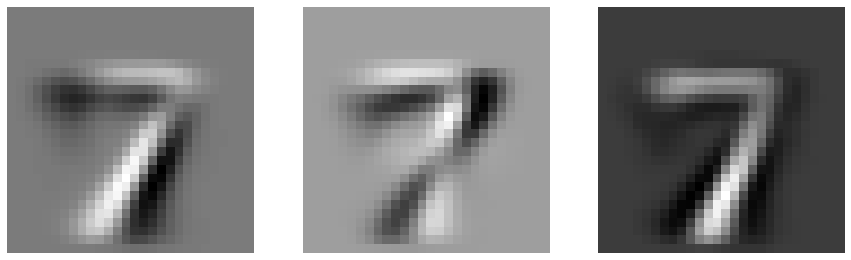

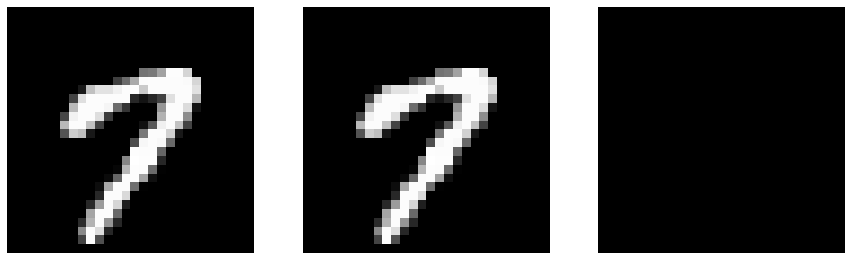

In [ ]:
# This tests if your functions are correct, you should get the same output as we do
X_mean, components = pca(X,n_components=None)

# Reshapes the reconstructed data to have 28x28 pictures
comp_ = np.reshape(components,(28,28,784))

fig, axes = plt.subplots(1,3,figsize=(15,100))
plt.rcParams['image.cmap'] = 'gray'
axes[0].imshow(comp_[:,:,-1])
axes[1].imshow(comp_[:,:,-2])
axes[2].imshow(comp_[:,:,-3])
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

X_projected = pca_project(X,X_mean,components)

X_ = np.reshape(X_projected.T,(28,28,3133))
fig, axes = plt.subplots(1,3,figsize=(15,100))
plt.rcParams['image.cmap'] = 'gray'
axes[0].imshow(train_set[:,:,0])
axes[1].imshow(X_[:,:,0])
axes[2].imshow(train_set[:,:,0]-X_[:,:,0]>10**(-12))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

#### Testing PCA 

You now have a (hopefully) working implementation of the Principal Component Analysis algorithm. Use it to fit your training set and observe the results on the testing set.

<a id='q2'></a>
<b>Question 2.</b> Use the function `pca(.)` to learn a decomposition on the <b>training set</b>. Then compute the reconstruction error $E$ on the <b>testing set</b>, for a number of components varying from 1 to 100, as defined by: 
$$
E(D) = \frac{1}{N}\sum_{n=1}^N \|I_n - (\mathbf{\mu}+\sum_{k=1}^D \omega_k^n\mathbf{u}_k) \|_2,
$$
with $I_n$ denoting the $n$-th image of the testing set, $\mathbf{\mu}$ is the mean digit learnt from the training set, $\mathbf{u}_k$ is the eigenvector with the $k$-th largest eigenvalue, and $\omega_k^n$ is the expansion coefficient of the $n$-th image on the $k$-th eigenvector. Finally, $\|.\|_2$ denotes the $L_2$ norm. Numpy has the method `np.linalg.norm(.)` that computes norms (check out the documentation for more infos).
<br/>


In [ ]:
max_n_components = 100 # Max number of components to keep

xrange = range(1,max_n_components+1)
error = []

##################### TO DO QUESTION 2 ##############################

# Compute the Error for n_components between 1 and 100

for i in xrange:
    X_mean, components = pca(X, n_components = i)
    e = np.sum(np.linalg.norm(Y - pca_project(Y,X_mean,components)))
    error.append(e)
error = np.array(error)/Y.shape[0]

##################### TO DO QUESTION 2 ##############################

<a id='q3'></a>
<b>Question 3.</b> Plot the evolution of the error $E$ for $D = 1,\ldots,100$.

Text(0.5, 1.0, 'Error through components')

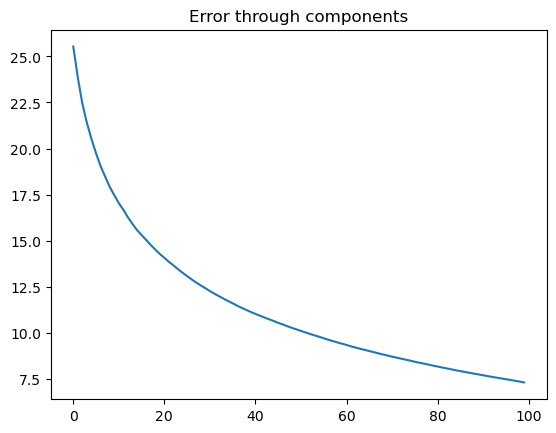

In [ ]:
##################### TO DO QUESTION 3 ##############################

# Plot the error with respect to n_components
plt.style.use('default')
plt.plot(error)
plt.title('Error through components')

##################### TO DO QUESTION 3 ##############################

<a id='kmeans'></a>
# K-Means

In this section, you will complete the implementation of the k-means algorithm.

<a id='q4'></a>
<b>Question 4.</b>  Complete the function `distortion(.)` which computes the distortion cost $F$ for a given clustering of the data:
$$
F(m,c) = \frac{1}{N}\sum_{i=1}^N \|x^i - c^{m(i)}\|_2,
$$
where $N$ corresponds to the total number of images in the set and $m(i)$ denotes which cluster is assigned to the image $x^i$.<br/>

In [ ]:
def distortion(X, cluster_assignment, centroids):
    
    n_cluster, n_variables = centroids.shape
    distortion = 0
    
    ##################### TO DO QUESTION 4 ##############################
    
    # Compute distortion
        
    ##################### TO DO QUESTION 4 ##############################
        
    return distortion/X.shape[0]

<a id='q5'></a>
<b>Question 5.</b> Complete the functions `K-means` and `assign_cluster(.)`, make sure that it computes the distortion after each update. Then use the function on your training set, the number of cluster $k = 2$. Check that the distortion decreases as the algorithm progresses.<br/>

In [ ]:
def assign_cluster(centroids, X):
    
    n_observations, _ = X.shape
    # Initialise cluster_assignment to -1
    cluster_assignment = -1*np.ones((n_observations,))
    
    for i in range(n_observations):
        ##################### TO DO QUESTION 5 ##############################
        
        
        ##################### TO DO QUESTION 5 ##############################
        
    return cluster_assignment

def kmeans(X, n_clusters = 2, max_iter =1000, tol = 10**-10, verbose = False):
    
    n_observations, n_variables = X.shape
    
    # Randomly initialise the centroids using the multivariate gaussian computed from the data
    X_mean = np.mean(X,axis=0)
    X_cov = np.cov(X,rowvar=False)
    centroids = np.random.multivariate_normal(X_mean,X_cov,(n_clusters,))
    
    n_iter = 0
    distortion_scores = []
    # Loop as long as the number of iterations is below max_iter and if the converging criteria has not be met
    while (n_iter < max_iter):
        n_iter += 1
        # Step 1: assign points to nearest center
        cluster_assignment = assign_cluster(centroids,X)
        
        # Step 2: compute distortion
        dist = distortion(X, cluster_assignment, centroids)
        distortion_scores.append(dist)
        if verbose:
            print("Iteration %s, distortion = %s" % (n_iter,dist))
              
        # Step 3: compute new centroids from the clusters
        new_centroids = np.zeros(centroids.shape)
        for j in range(n_clusters):
            
            ##################### TO DO QUESTION 5 ##############################
            
        
            ##################### TO DO QUESTION 5 ##############################
            
        # Step 4: break the loop if difference between previous centroids and new ones is small enough
        if np.linalg.norm(new_centroids-centroids)<tol:
            if verbose:
                print("Terminates with difference: %s\n" % np.linalg.norm(new_centroids-centroids))
            break
        else:
            centroids = new_centroids
    
    return cluster_assignment, centroids, distortion_scores

In [ ]:
# If your implementation is correct you should get the same results as us here
np.random.seed(11) # DO NOT CHANGE THIS LINE, it ensures your random initialisation is identical to ours

cluster_assignment, centroids, distortion_scores = kmeans(X,verbose=True)

Iteration 1, distortion = 2090.7481389717063
Iteration 2, distortion = 1452.3091110197047
Iteration 3, distortion = 1447.6490543130699
Iteration 4, distortion = 1446.005894465188
Iteration 5, distortion = 1444.893372279777
Iteration 6, distortion = 1444.208120556854
Iteration 7, distortion = 1443.8045936541398
Iteration 8, distortion = 1443.6018478205244
Iteration 9, distortion = 1443.5087750077328
Iteration 10, distortion = 1443.434478685969
Iteration 11, distortion = 1443.3888422890182
Iteration 12, distortion = 1443.365125904968
Iteration 13, distortion = 1443.3344999721164
Iteration 14, distortion = 1443.284897951173
Iteration 15, distortion = 1443.267950454885
Iteration 16, distortion = 1443.2627485947248
Terminates with difference: 0.0



In [ ]:
# Helper function to plot multiple images (non-graded)
def plot_kmeans(centroids, n = 4):
    
    k = centroids.shape[0]
    m = int(np.ceil(k/n))
    fig, axes = plt.subplots(m,n,figsize=(n*5,m*5))
    plt.rcParams['image.cmap'] = 'gray'
    for c in range(k):
        if m == 1:
            axes[c].imshow(np.reshape(centroids[c,:],(28,28)))
            axes[c].axis('off')
        else:
            i, j = int(c/n), int(c - i*n)
            axes[i,j].imshow(np.reshape(centroids[c,:],(28,28)))
            axes[i,j].axis('off')
            
    for c in range(k,m*n):
        if m == 1:
            axes[c].remove()
            axes[c].axis('off')
        else:
            i, j = int(c/n), int(c - i*n)
            axes[i,j].remove()
            axes[i,j].axis('off')
    

#### Testing K-means

<a id='q6'></a>
<b>Question 6.</b> In order to mitigate the local minima problem of K-Means, repeat the algorithm 10 times, and keep the solution that yields the smallest distortion at the end. Show the resulting digit clusters (centroids of your clusters) using the `plot_kmeans(.)` function given.<br/>


Run k=2: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 


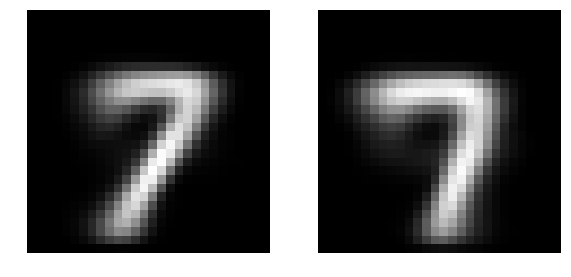

In [ ]:
def select_clustering(X,k=2,repeats=10):
    # Returns clustering with lowest distortion across "repeats" number of runs
    clustering = None
    print("Run k=%s:" % k,end=' ')
    
    
    for i in range(repeats):
        print("%s/%s.." % (i+1,repeats), end=' ')
        np.random.seed(i) # Do not change this line, it insures you get the same random initialisation as us
        
        ##################### TO DO QUESTION 6 ##############################
        
        # Compute clusters and retrieve the one with lowest distortion
            
        ##################### TO DO QUESTION 6 ##############################
            
    print("\n",end='')
    return clustering


clustering = select_clustering(X)

##################### TO DO QUESTION 6 ##############################

# Plot the centres of the clusters

##################### TO DO QUESTION 6 ##############################


<a id='q7'></a>
<b>Question 7.</b> Repeat the procedure of Question 6 for values of $k = 3,4,5,10,50,100$ (Allow for ~10min). Plot the evolution of the distortion cost of the training and testing data. Remember to use the functions `select_clustering(.)`, `assign_cluster(.)`, and `distortion(.)` defined earlier.

In [ ]:
train_distortions = []
test_distortions = []

ks = [2,3,4,5,10,50,100]


##################### TO DO QUESTION 7 ##############################


##################### TO DO QUESTION 7 ##############################

Run k=2: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=3: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=4: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=5: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=10: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=50: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=100: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 


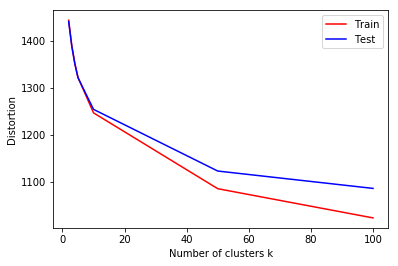

In [ ]:
# Plotting the evolution of distortion for train and test set
fig = plt.figure()

##################### TO DO QUESTION 7 ##############################


##################### TO DO QUESTION 7 ##############################

plt.xlabel("Number of clusters k")
plt.ylabel("Distortion")
plt.legend(['Train', 'Test'])

<a id='comparison'></a>
# Comparison

<a id='q8'></a>
<b>Question 8.</b> Compare the results from PCA to the results of K-means on the <b>test set</b> by plotting on the same graph the reconstruction error $E(D)$ for $D = 3,4,5,10,50,100$ and the distortion cost you just computed (remark that the two measures are simply L$_2$ norms thus the comparison is valid). To be clear, the first one measure the error in the reconstructed image from the projection on the components of PCA, the second measure the error between each image and the centroid of the cluster it is assigned to. Both correpond to the error made when approximating the original image to either its projection or its cluster's centroid.

In [ ]:
# No need to recompute kmeans here, just compute PCA for the corresponding values of k (similar to question 2/3)

n_components = [2,3,4,5,10,50,100] # Max number of components to keep

error = []

##################### TO DO QUESTION 8 ##############################

    
##################### TO DO QUESTION 8 ##############################

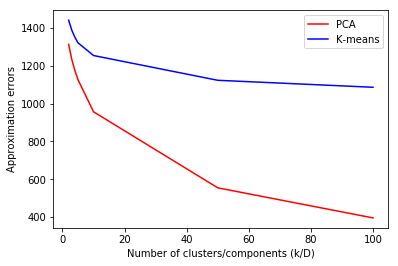

In [ ]:
# Plotting the comparison

fig = plt.figure()

##################### TO DO QUESTION 8 ##############################


##################### TO DO QUESTION 8 ##############################

plt.xlabel("Number of clusters/components (k/D)")
plt.ylabel("Approximation errors")

plt.legend(['PCA', 'K-means'])